1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 770ms/step

Image 1 - images/pug_145.jpg
Original prediction: Class 1, Probability 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step

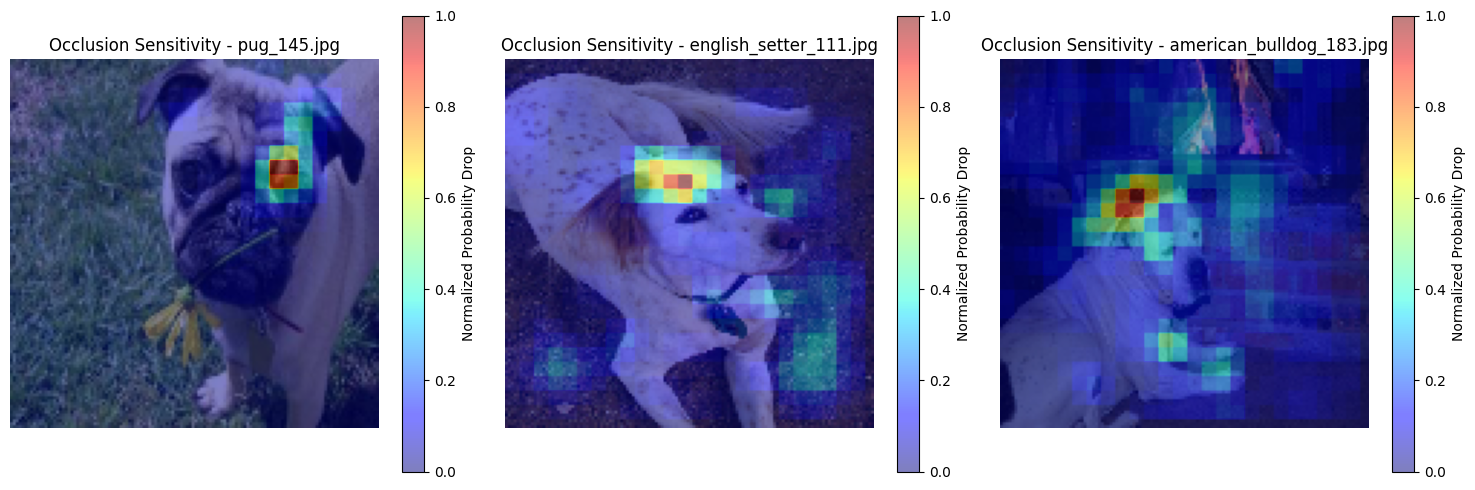

In [ ]:
# Configuration
MODEL_PATH = "model.h5"
IMAGE_PATHS = ["data/images/pug_145.jpg", "data/images/english_setter_111.jpg", "data/images/american_bulldog_183.jpg"]
INPUT_SIZE = (128, 128)
PATCH_SIZE = 10
STRIDE = 5

import numpy as np
import cv2
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input
import matplotlib.pyplot as plt
import pandas as pd

def load_and_preprocess_image(image_path, target_size):
    """Load an image, convert to RGB, resize, and normalize."""
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at path: {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, target_size)
    img = img.astype("float32") / 255.0
    return np.expand_dims(img, axis=0)

def compute_occlusion_sensitivity(model, input_image, original_class, original_prob, patch_size, stride):
    """
    Compute occlusion sensitivity by sliding a gray patch over the image.
    Return a heatmap of probability changes.
    """
    # Convert back to uint8 for drawing operations
    image_uint8 = (input_image[0] * 255).astype(np.uint8)
    H, W = image_uint8.shape[:2]
    sensitivity_map = np.zeros((H, W))
    count_map = np.zeros((H, W))  # Keep track of overlapping regions

    for y in range(0, H - patch_size, stride):
        for x in range(0, W - patch_size, stride):
            occluded = image_uint8.copy()
            # Draw a gray occlusion patch
            cv2.rectangle(occluded, (x, y), (x+patch_size, y+patch_size), (125, 125, 125), -1)
            # Re-normalize and predict again
            occluded_input = np.expand_dims(occluded.astype(np.float32)/255.0, axis=0)
            prob = model.predict(occluded_input)[0, original_class]

            # Calculate absolute change in probability
            prob_change = abs(original_prob - prob)

            # Accumulate the change and count for averaging
            sensitivity_map[y:y+patch_size, x:x+patch_size] += prob_change
            count_map[y:y+patch_size, x:x+patch_size] += 1

    # Average out the overlapping regions
    count_map[count_map == 0] = 1  # Avoid division by zero
    sensitivity_map = sensitivity_map / count_map

    return sensitivity_map

def plot_occlusion_heatmap(original_image, heatmap, title):
    """Plot the occlusion sensitivity heatmap over the original image."""
    # Consider only positive changes
    heatmap = np.maximum(heatmap, 0)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()  # Normalize to [0,1]
    else:
        print(f"No significant change in probability detected with occlusion for {title}")
        plt.imshow(original_image)
        plt.axis('off')
        plt.title(f"No Change Detected - {title}")
        return

    # Show the original image
    plt.imshow(original_image)

    # Use a sequential colormap like 'jet' and no negative values
    im = plt.imshow(heatmap, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Occlusion Sensitivity - {title}")

    # Add a colorbar for scale reference
    cbar = plt.colorbar(im)
    cbar.set_label('Normalized Probability Drop')

def process_all_images(model_path, image_paths, input_size, patch_size, stride):
    """Process multiple images and display their heatmaps."""
    # Load model
    model = load_model(model_path)

    # Create a figure with subplots for all images
    fig = plt.figure(figsize=(15, 5))

    # Process each image
    for idx, image_path in enumerate(image_paths, 1):
        try:
            # Load and preprocess image
            input_image = load_and_preprocess_image(image_path, input_size)

            # Get original prediction and probability
            original_preds = model.predict(input_image)
            original_class = np.argmax(original_preds[0])
            original_prob = original_preds[0, original_class]

            print(f"\nImage {idx} - {image_path}")
            print(f"Original prediction: Class {original_class}, Probability {original_prob:.4f}")

            # Compute occlusion sensitivity
            heatmap = compute_occlusion_sensitivity(
                model, input_image, original_class, original_prob, patch_size, stride
            )

            # Convert the normalized input image back to displayable RGB (0-255)
            image_for_display = (input_image[0] * 255).astype(np.uint8)

            # Create subplot
            plt.subplot(1, 3, idx)
            # Extract filename from path
            filename = image_path.split('/')[-1]
            plot_occlusion_heatmap(
                image_for_display,
                heatmap,
                filename
            )

        except Exception as e:
            print(f"Error processing image {image_path}: {str(e)}")
            continue

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

# --- Main Execution ---
if __name__ == "__main__":
    process_all_images(MODEL_PATH, IMAGE_PATHS, INPUT_SIZE, PATCH_SIZE, STRIDE)